## PHY 411: Final Project
### Jeremy Kazimer
### 5018-1732

---

#### _Import Statements_

To begin this portion of the project, we import the Python file I created which contains the network class and its methods:

In [1]:
from generate_network import *

Consider that an explanation of the code is partially within the .py itself, but also in the documentation on GitHub.  We can also import `numpy` and `matplotlib` such that we can use their code here:

In [4]:
import numpy as np
from matplotlib import pyplot as plt

Now, we can begin to generate networks.

#### _Generating Networks_

For an Erdős–Rényi network, the only parameters needed to create it are the numbers of nodes $N$ and the edge probability $p$.  These generate a random number of edges each time, but in general it gravitates around the value

\begin{equation}
\bar{M} = \dfrac{N\left[N - 1\right]}{2} \cdot p
\end{equation}

The derivation of this can be found in theory.  Furthermore, the graph is random in the sense that their placement with respect to the nodes is also random.  With that, since both of those conditions are random but constrained according to the initial conditions, we can take that into consideration later with respect to the Monte Carlo simulation.  Regardless, we can generate a network with the following conditions:

In [5]:
N = 100
p = 0.25

In [6]:
G = Erdos_Renyi_GNP(N, p)

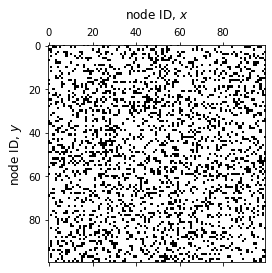

In [8]:
fig, ax = G.plot_graph()

With that, we can validate properties of our network:

#### _Graph Validation_

There are a few ways to verify that our creation is vaguely correct.  Remember that it is random and therefore there are not always exact values to compare.  The first we can do is assert that the shape of the adjacency is $N \times N$:

In [11]:
assert(G.A.shape == (N, N))

Moreover, the number of edges should vaguely be between

\begin{equation}
\dfrac{N\left[N - 1\right]}{2} \cdot p
\end{equation}

Although we don't have a precise form for a standard deviation right now, for now we can treat it as 

\begin{equation}
\sigma_{\bar{M}} = 10\% \cdot \bar{M}
\end{equation}

In [26]:
bar_m = lambda N, p: N*(N - 1)/2 * p
std_m = lambda N, p: 0.10 * bar_m(N, p)

In [28]:
assert((G.M < bar_m(N, p) + std_m(N, p)) and (G.M > bar_m(N, p) - std_m(N, p)))

Just to assert that this isn't the case for just this particular graph, we can iterate over and do the same:

In [30]:
for _ in range(1000):
    G1 = Erdos_Renyi_GNP(N, p)
    assert((G1.M < bar_m(N, p) + std_m(N, p)) and (G1.M > bar_m(N, p) - std_m(N, p)))

Besides that, we can also check that the length of the current edges (values of 1) and the length of the potential edges (values of 0) sum to be the total possible number of edges

\begin{equation}
\dfrac{N\left[N - 1\right]}{2}
\end{equation}

In [35]:
assert(G.edges.shape[0] == G.M)
assert(G.edges.shape[0] + G.potential_edges.shape[0] == G.N*(G.N - 1)/2)

## To be continued...